## Project 1
## Elevator System Simulation and Analysis
### This project is intended to introduce some of the tools in Python for use in the analysis of dynamical systems. 
                                    
         
   #### Submitted By: Mahbub Rahman
            

In [339]:
import numpy as np
import sympy as sp
from sympy import *
import scipy
from scipy import signal
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d

## Define the constants

In [340]:
I_m = 700.0 # Nm, momentum of inertia
k = 100.0 # Nm/A, motor characteristic
L = 0.4 # H, inductance of the motor
m = 500.0 # kg
g = 9.81 # m/s^2
W = 300.0 # x g N
r_0 = 3.0 # m
delta_c = 0.05 # m, radial increase due to a full rotationn, i.e. 𝜔 = 2𝜋, of the disk
R_0 = 5.0 # ohm
delta_R = 5.0 # ohm, resistance varies with time as the motor heats up
tao_R = 3.0 # s
tspan = np.linspace(0,3,301)


## Input V(t)

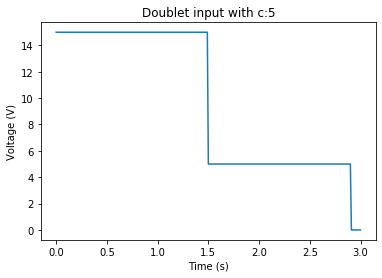

In [341]:
c = 5
input_array = np.zeros((len(tspan)))
input_array[:len(input_array)//2] += c+10
input_array[len(input_array)//2:len(input_array)-10] -= c-10
plt.plot(tspan,input_array)
plt.title('Doublet input with c:'+str(c))
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')

v= interp1d(tspan,input_array,fill_value="extrapolate")

## Find the state vectors

In [342]:
def find_states(x,t,v):
    x_dot = x[1]
    i_t = x[2]
    r_t = r_0+x[3]   
    dx    = np.zeros((len(x)))

    dx[0] = x_dot
    dx[1] = np.array(1/(m*r_t-I_m/r_t)) * np.array(W*r_t - m*g*r_t + k*i_t - I_m*delta_c*x_dot**2/(2*np.pi*r_t**3)) 
    dx[2] = 1/L*v(t) - np.array(R_0+delta_R*(1-math.exp(-t/tao_R)))/L*np.array(i_t) - k*x_dot/(L*r_t)
    dx[3] = delta_c/(2*np.pi*r_t)*x_dot
    return dx

## Find the output vectors

In [343]:
def find_op(dx,t):
    op = dx
    return op

## Equilibrium Points Computaiton @ x_bar = 0,15,30

In [344]:
def equi_states(x_bar):
    
    r_bar=(delta_c*x_bar/np.pi+r_0**2)**0.5
    v_bar=(m*g-W)*(R_0+delta_R)/k * r_bar
    i_bar= 1/(R_0+delta_R) * v_bar
    rbar=(k/(m*g-W))*i_bar
    xdot_bar=0
    return xdot_bar,rbar,i_bar


In [345]:
x_bar=15 # Set trim point at x=0,15,30
xdot_bar,r_bar,i_bar=equi_states(x_bar)
x_eq= [x_bar,xdot_bar,i_bar,r_bar]
print(x_eq)

[15, 0, 139.97027918566158, 3.039528321078427]


## Compute the states with equilibriam points as the initial states

In [346]:
stats_vec = odeint(find_states, x_eq, tspan, args=(v,))
Op_y = find_op(stats_vec[:,0:2], tspan)

Text(0.5, 0, 'Time (s)')

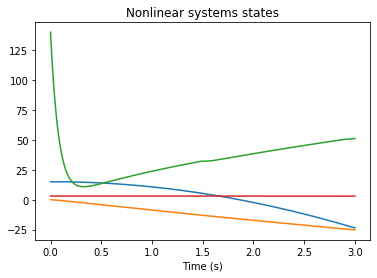

In [347]:
plt.plot(tspan,stats_vec)
plt.title('Nonlinear systems states')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

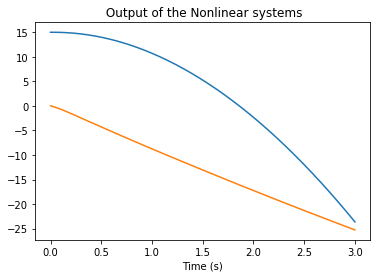

In [348]:
plt.plot(tspan,Op_y)
plt.title(' Output of the Nonlinear systems')
plt.xlabel('Time (s)')

## Q2. Jacobian Linearization

In [349]:
x, u, x_dot, i_t, r_t = sp.symbols(['x','u','x_dot','i_t','r_t'])
J = Matrix([[x_dot], 
            [1/(m*r_t - I_m/r_t) * (W*r_t - m*g*r_t + k*i_t - (I_m*delta_c*x_dot**2)/(2*pi*r_t**3))],
            [1/L*u - (R_0+delta_R)/L*i_t - k*x_dot/(L*r_t)],
            [delta_c/(2*pi*r_t)*x_dot]])
J

Matrix([
[                                                                       x_dot],
[(100.0*i_t - 4605.0*r_t - 17.5*x_dot**2/(pi*r_t**3))/(500.0*r_t - 700.0/r_t)],
[                                         -25.0*i_t + 2.5*u - 250.0*x_dot/r_t],
[                                                        0.025*x_dot/(pi*r_t)]])

In [350]:
A = J.jacobian([[x], [x_dot], [i_t], [r_t]])
A.subs(x_dot,0)
A


Matrix([
[0,                                               1,                             0,                                                                                                                                                                       0],
[0, -35.0*x_dot/(pi*r_t**3*(500.0*r_t - 700.0/r_t)), 100.0/(500.0*r_t - 700.0/r_t), (-4605.0 + 52.5*x_dot**2/(pi*r_t**4))/(500.0*r_t - 700.0/r_t) + (-500.0 - 700.0/r_t**2)*(100.0*i_t - 4605.0*r_t - 17.5*x_dot**2/(pi*r_t**3))/(500.0*r_t - 700.0/r_t)**2],
[0,                                      -250.0/r_t,                         -25.0,                                                                                                                                                      250.0*x_dot/r_t**2],
[0,                                  0.025/(pi*r_t),                             0,                                                                                                                                                -0

In [351]:
B = J.jacobian(['u'])
B

Matrix([
[  0],
[  0],
[2.5],
[  0]])

In [352]:
C = np.array([[1,0,0,0],[0,1,0,0]])
C

array([[1, 0, 0, 0],
       [0, 1, 0, 0]])

In [353]:
D = np.zeros((2,1))
D

array([[0.],
       [0.]])

In [354]:
def subs_equi(x0):
    A2 = A.subs([(x,x0[0]),(x_dot,x0[1]),(i_t,x0[2]),(r_t,x0[3]),(sp.pi,np.pi)])
    return np.array(A2)

In [355]:
A_equi = subs_equi(x_eq)
A_equi

array([[0, 1, 0, 0],
       [0, 0, 0.0775515264534988, -3.57124779318362],
       [0, -82.2496037514465, -25.0000000000000, 0],
       [0, 0.00261808620087848, 0, 0]], dtype=object)

In [356]:
lin_sys = scipy.signal.StateSpace(A_equi,B,C,D)
lin_sys

StateSpaceContinuous(
array([[0, 1, 0, 0],
       [0, 0, 0.0775515264534988, -3.57124779318362],
       [0, -82.2496037514465, -25.0000000000000, 0],
       [0, 0.00261808620087848, 0, 0]], dtype=object),
array([[0],
       [0],
       [2.50000000000000],
       [0]], dtype=object),
array([[1, 0, 0, 0],
       [0, 1, 0, 0]]),
array([[0.],
       [0.]]),
dt: None
)

In [357]:
tt,yout,x_out = scipy.signal.lsim(lin_sys, input_array, tspan, X0=x_eq, interp=1)

Text(0.5, 0, 'Time (s)')

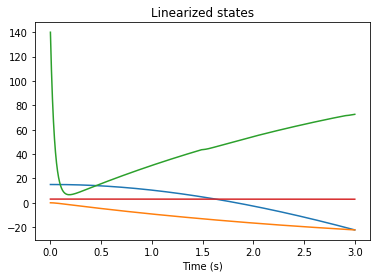

In [358]:
plt.plot(tt,x_out)
plt.title('Linearized states')
plt.xlabel('Time (s)')

## Stability

In [359]:
EigA= np.linalg.eig(A_equi.astype(float))
EigA

(array([  0.        , -24.74220222,  -0.21356099,  -0.0442368 ]),
 array([[ 1.00000000e+00, -1.26679073e-04,  8.03784081e-01,
          9.88588199e-01],
        [ 0.00000000e+00,  3.13431924e-03, -1.71656923e-01,
         -4.37319742e-02],
        [ 0.00000000e+00, -9.99995080e-01,  5.69614452e-01,
          1.44132540e-01],
        [ 0.00000000e+00, -3.31656733e-07,  2.10437601e-03,
          2.58820912e-03]]))

### First eignvalue is 0, this means it's not possible to determine whether this system is stable or not. 

## Controlability

In [360]:
import control
from control import ctrb,obsv
ctrb_mat=ctrb(A_equi.astype(float), B)
rnk=np.linalg.matrix_rank(ctrb_mat)
rnk

3

### The rank of the matrix is less than 4, there are dependent columns. So the system is not controlable




## Observability

In [361]:
obsv_mat=obsv(A_equi.astype(float), C)
rnk_obs=np.linalg.matrix_rank(obsv_mat)
rnk_obs

4

### It's full Rank, so the system is observable, i.e., we can estiamte states from output




## Q3. Nonlinear system with Initial Condition closer and far from the equilibrium point


#### Closer to the equilibrium point

In [364]:
close_offset=50
x_close_eq = [x_add + close_offset for x_add in x_eq]
x_close_eq

[65, 50, 189.97027918566158, 53.03952832107843]

Text(0.5, 0, 'Time (s)')

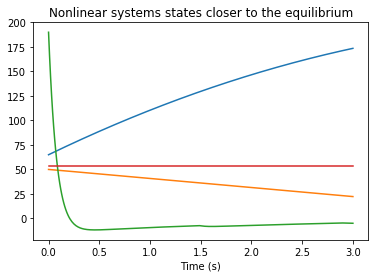

In [365]:
stats_vec2 = odeint(find_states, x_close_eq, tspan, args=(v,))
Op_y2 = find_op(stats_vec2[:,0:2], tspan)

plt.plot(tspan,stats_vec2)
plt.title('Nonlinear systems states closer to the equilibrium')
plt.xlabel('Time (s)')

#### Far from the equilibrium

In [366]:
far_offset=180
x_far_eq = [x_add + far_offset for x_add in x_eq]
x_far_eq


[195, 180, 319.9702791856616, 183.03952832107842]

Text(0.5, 0, 'Time (s)')

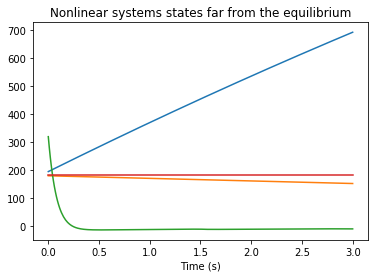

In [367]:
stats_vec3 = odeint(find_states, x_far_eq, tspan, args=(v,))
Op_y3 = find_op(stats_vec3[:,0:2], tspan)

plt.plot(tspan,stats_vec3)
plt.title('Nonlinear systems states far from the equilibrium')
plt.xlabel('Time (s)')

## Q4. linearized system with Initial Condition closer and far from the equilibrium point



#### closer to the equilibrium

Text(0.5, 0, 'Time (s)')

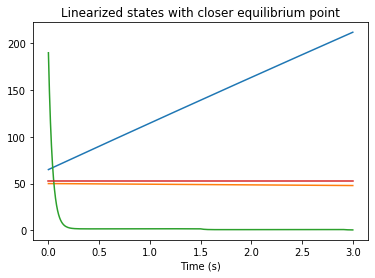

In [368]:
A_closer_equi = subs_equi(x_close_eq)
lin_sys = scipy.signal.StateSpace(A_closer_equi,B,C,D)
tt,yout_closer,x_out_closer = scipy.signal.lsim(lin_sys, input_array, tspan, X0=x_close_eq, interp=1)
plt.plot(tt,x_out_closer)
plt.title('Linearized states with closer equilibrium point')
plt.xlabel('Time (s)')





#### Far from the equilibrium points

Text(0.5, 0, 'Time (s)')

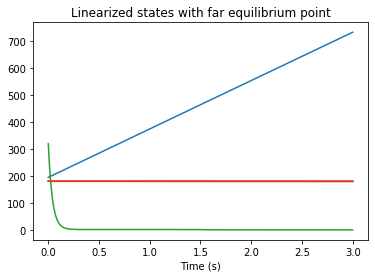

In [369]:
A_far_equi = subs_equi(x_far_eq)
lin_sys = scipy.signal.StateSpace(A_far_equi,B,C,D)
tt,yout_far,x_out_far = scipy.signal.lsim(lin_sys, input_array, tspan, X0=x_far_eq, interp=1)
plt.plot(tt,x_out_far)
plt.title('Linearized states with far equilibrium point')
plt.xlabel('Time (s)')





## Q5. Compare Nonlinear with Linearized system @ x=15

Text(0.5, 1.0, ' compare Nonlinear and Linearized states @ trim point x=15')

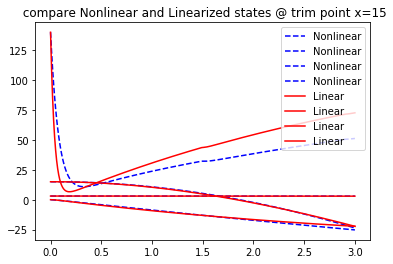

In [338]:
plt.plot(tspan,stats_vec,'--b',label='Nonlinear')
plt.plot(tt,x_out,'r',label='Linear')
plt.legend(loc="upper right")
plt.title(' compare Nonlinear and Linearized states @ trim point x=15')


#### This project is all about simulating Elevator as an electromechanical systems which  can be described by the nonlinear 
#### dynamical system as stated by the equaiton 23. It takes single input voltage v(t) as input with 4 states, 
#### namely x, x_dot,i,r and 2 output x, x_dot.  This system is simulated for a trim condition of x= 0,15 and 30 to find 
#### the equilibrium states and outputs. The input is a dublet function with 3 sec duration. 
#### Later on, the system is linearized by calculating jacobian to find A and B matrices at the equilibrium point.
#### Once the system is linearized around the equilibrium point, system's stability, controlability and observablity
#### has been analyzed and we found that this system is not stable, nor controlable. However, this system is observable.
#### Furthermore, the simulaiton is extended in Q3 and Q4 to find the states of the nonlinear and linearized systems at a point 
#### closer and far from the equilibrium point. Those results are presented in the respective sections.
#### Finally, the nonlinear and linearized states were compared in Q5 and we can see that the they agree with each other.
